# Optimisation: First example

This example shows you how to run an optimisation with Pints.

First, we import pints:

In [1]:
import pints

Next, we need an [ErrorMeasure](https://pints.readthedocs.io/en/stable/error_measures.html) to minimise, or alternatively a [LogPDF](https://pints.readthedocs.io/en/stable/log_pdfs.html#pints.LogPDF) (representing a distribution) to maximise.

For now, we will define a very simple parabola:

In [2]:
class MyError(pints.ErrorMeasure):
    
    def n_parameters(self):
        # This method tells the optimiser the dimensionality of the problem
        return 1
    
    def __call__(self, p):
        # This method accepts a vector of n_parameters parameters, and
        # should return a scalar error.
        x = p[0]
        return (x - 10)**2
    
error = MyError()
print(error([1]))
print(error([5]))
print(error([9.9]))

81
25
0.009999999999999929


Next, we call on PINTS to find the parameter vector (in this case containing just a single value) that minimises our error function:

In [3]:
# Define an initial guess
x0 = [1]

# Run an optimisation
found_parameters, found_value = pints.optimise(error, x0, method=pints.NelderMead)

Minimising error measure
Using Nelder-Mead
Running in sequential mode.
Iter. Eval. Best      Current   Time    
0     2      81        81         0:00.0
1     3      80.1025   80.1025    0:00.0
2     4      80.1025   80.1025    0:00.0
3     5      78.3225   78.3225    0:00.0
20    22     0.0625    0.0625     0:00.0
40    42     1.14e-28  1.14e-28   0:00.0
60    62     1.14e-28  1.14e-28   0:00.0
80    82     1.14e-28  1.14e-28   0:00.0
100   102    1.14e-28  1.14e-28   0:00.0
120   122    0         0          0:00.0
140   142    0         0          0:00.0
160   162    0         0          0:00.0
180   182    0         0          0:00.0
200   202    0         0          0:00.0
220   222    0         0          0:00.0
228   229    0         0          0:00.0
Halting: No significant change for 200 iterations.


Anything that can be made to fit the [ErrorMeasure](https://pints.readthedocs.io/en/stable/error_measures.html#pints.ErrorMeasure) interface can be optimised this way, including error measures that run simulations, make calls to other software packages, or even other languages.

If you are interested in _time-series models_, you can implement PINTS `ForwardModel` interface instead, as is shown below.

## Fitting time-series models

To fit time-series models, we start by defining a Model by implementing the [pints.ForwardModel interface](http://pints.readthedocs.io/en/latest/core_classes_and_methods.html#forward-model).

As with the error function above, there are only two main methods: One to tell the optimiser how many parameters the are, and one to run the simulations.

We won't give a full example here, but typically it will look a bit like this:

In [4]:
class MyModel(pints.ForwardModel):
    def __init__(self):
        # Here, we might instantiate a simulation using some
        # external simulation library
        self.simulation = ...
    
    def n_parameters(self):
        # Define the number of parameters you'll want to optimise
        return 10
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters, log all the results
        # at the given times, and return
        self.simulation.set_parameters(parameters)
        return self.simulation.run(times)

To keep it simple, we will use a predefined model from [PINTS' toy model collection](http://pints.readthedocs.io/en/latest/toy/index.html): in this case a [logistic model](https://en.wikipedia.org/wiki/Logistic_function).

In [5]:
import pints.toy as toy
model = toy.LogisticModel()

This model has two parameters: A growth rate (which determines the steepness of the curve) and a carrying capacity (which determines the number the curve converges to).
For the example, we simply pick some nice values:

In [6]:
real_parameters = [0.015, 500]

Finally, we create a list of times (in a real experiment, these would be the times at which the time series was sampled)

In [7]:
import numpy as np
times = np.linspace(0, 1000, 100)

We now have everything we need to run a simulation and generate some toy data:

In [8]:
values = model.simulate(real_parameters, times)

We can use Matplotlib (or any other plotting package) to have a look at the generated data:

In [9]:
import matplotlib.pyplot as plt

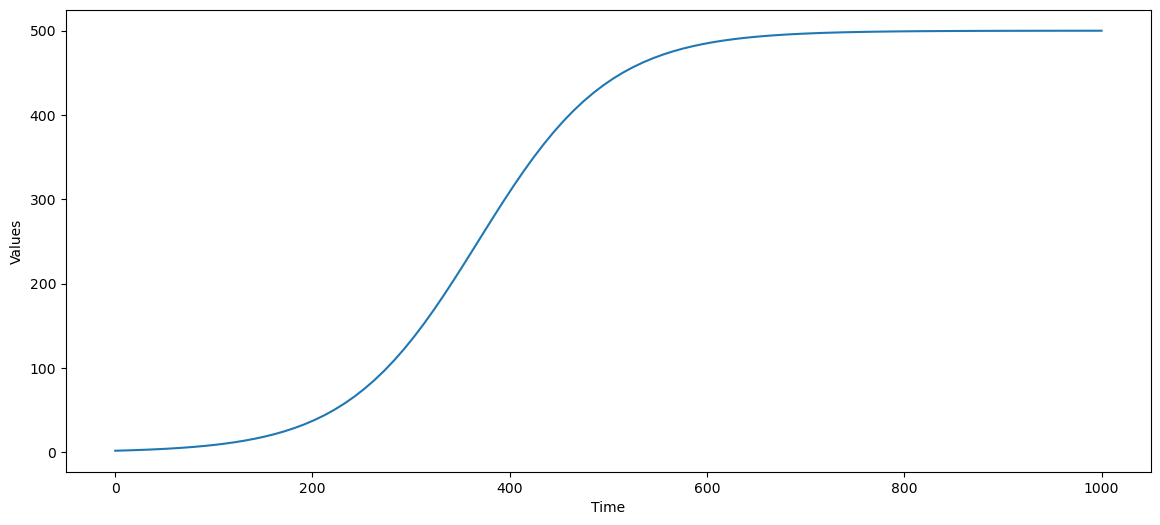

In [10]:
plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values)
plt.show()

We now set up an optimisation, to see if we can recover our original parameters from this data.

First, we define a problem (in this case a [single-valued time series fitting problem](https://pints.readthedocs.io/en/latest/core_classes_and_methods.html#pints.SingleOutputProblem)):

In [11]:
problem = pints.SingleOutputProblem(model, times, values)

We then define an [error measure](http://pints.readthedocs.io/en/latest/error_measures.html) on this problem:

In [12]:
error = pints.SumOfSquaresError(problem)

A lot of real problems have physical constraints on the values the parameters can take, so in this example we add them in the form of [boundaries](http://pints.readthedocs.io/en/latest/boundaries.html):

In [13]:
boundaries = pints.RectangularBoundaries([0, 200], [1, 1000])

Finally, we define an initial position to start searching at

In [14]:
x0 = np.array([0.5, 500])

We now run an optimisation, using the [xNES](http://pints.readthedocs.io/en/latest/optimisers/xnes.html) method (although we could also have used a different global [optimiser](http://pints.readthedocs.io/en/latest/optimisers/index.html), like [CMA-ES](http://pints.readthedocs.io/en/latest/optimisers/cmaes.html) or [PSO](http://pints.readthedocs.io/en/latest/optimisers/pso.html)):

In [15]:
found_parameters, found_value = pints.optimise(
    error,
    x0,
    boundaries=boundaries,
    method=pints.XNES,
    )

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     6      5328129   5328129    0:00.0
1     12     4349327   4349327    0:00.0
2     18     4076707   4076707    0:00.0
3     24     3535387   3535387    0:00.0
20    96     627361.6  3516860    0:00.0
40    201    627361.6  814038.2   0:00.1
60    321    195.0574  195.0574   0:00.1
80    441    0.0103    0.087      0:00.1
100   561    0.000687  0.000687   0:00.1
120   681    1.39e-07  1.45e-06   0:00.2
140   801    4.9e-10   1.14e-09   0:00.2
160   921    1.77e-14  1.77e-14   0:00.2
180   1041   3.62e-16  3.62e-16   0:00.2
200   1161   1.26e-19  5.09e-19   0:00.3
220   1281   4.91e-23  3.77e-22   0:00.3
240   1401   1.97e-25  2.02e-25   0:00.3
260   1521   0         1.86e-25   0:00.3
280   1641   0         0          0:00.3
300   1761   0         0          0:00.4
320   1881   0         0          0:00.4
340   2001   0 

We can now look at the quality of the fit by running a simulation with the obtained parameters and plotting it on top of the noisy data:

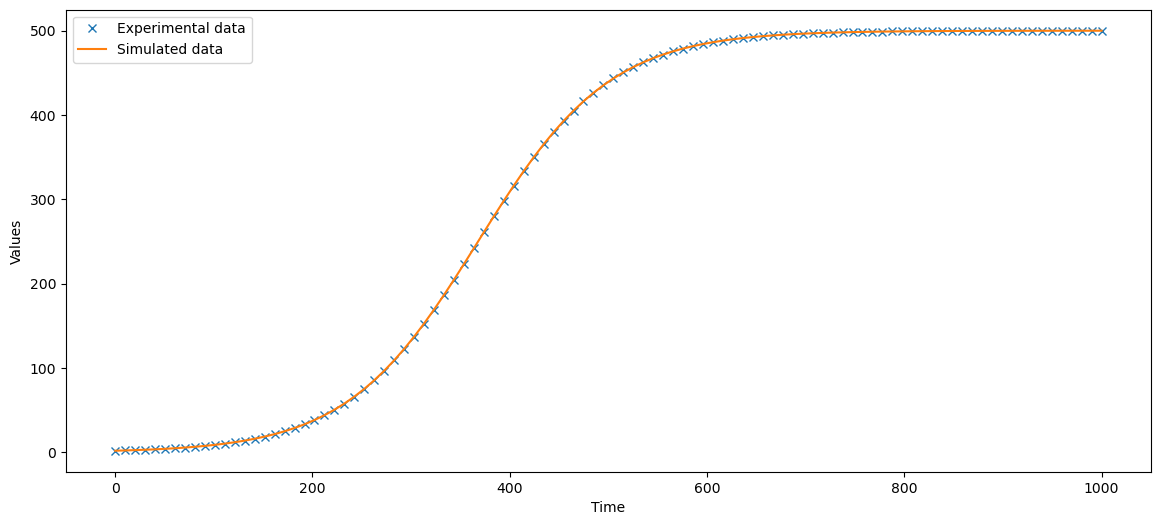

In [16]:
values2 = model.simulate(found_parameters, times)

plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, 'x', label='Experimental data')
plt.plot(times, values2, label='Simulated data')
plt.legend()
plt.show()

Because this was a toy model, we can also compare the parameters with the known true parameters:

In [17]:
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Found solution:          True parameters:
 1.49999999999999994e-02     1.49999999999999994e-02
 5.00000000000000000e+02     5.00000000000000000e+02


## Fitting to noisy data

We now repeat this exercise with noisy data:

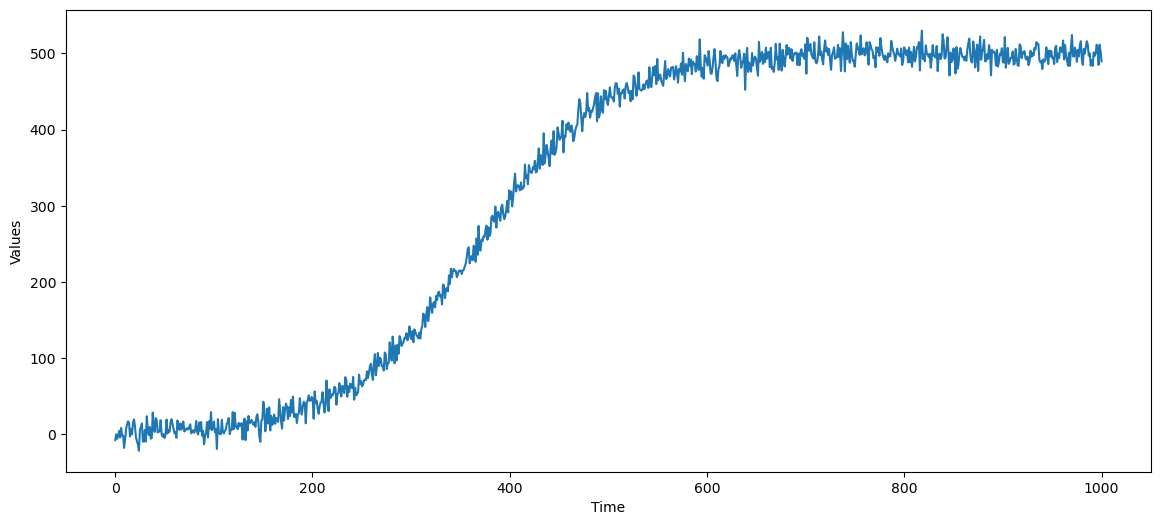

In [18]:
times = np.linspace(0, 1000, 1000)

values = model.simulate(real_parameters, times)
values += np.random.normal(size=values.shape) * 10

plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values)
plt.show()

Again, we set up a problem, define an error measure, and run the optimisation:

In [19]:
problem = pints.SingleOutputProblem(model, times, values)
error = pints.SumOfSquaresError(problem)

found_parameters, found_value = pints.optimise(
    error,
    x0,
    boundaries=boundaries,
    method=pints.XNES,
    )

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     5      3.88e+07  3.88e+07   0:00.0
1     10     3.88e+07  3.99e+07   0:00.0
2     16     2866401   2866401    0:00.0
3     22     2866401   4.26e+07   0:00.0
20    93     2866401   8453899    0:00.0
40    207    2866401   6668748    0:00.1
60    327    2866401   5054883    0:00.1
80    447    2866401   4616870    0:00.1
100   567    2866401   4175894    0:00.1
120   687    2866401   3874637    0:00.1
140   807    2866401   3764644    0:00.2
160   927    2866401   3573328    0:00.2
180   1047   2866401   3102832    0:00.2
200   1167   2595693   2595693    0:00.3
220   1287   862639.9  876587.1   0:00.3
240   1407   208132.5  208132.5   0:00.4
260   1527   108859.2  108953.2   0:00.4
280   1647   108836.7  108836.8   0:00.4
300   1767   108836.7  108836.7   0:00.5
320   1887   108836.7  108836.7   0:00.5
340   2007   10

And we can inspect the result by plotting a simulation:

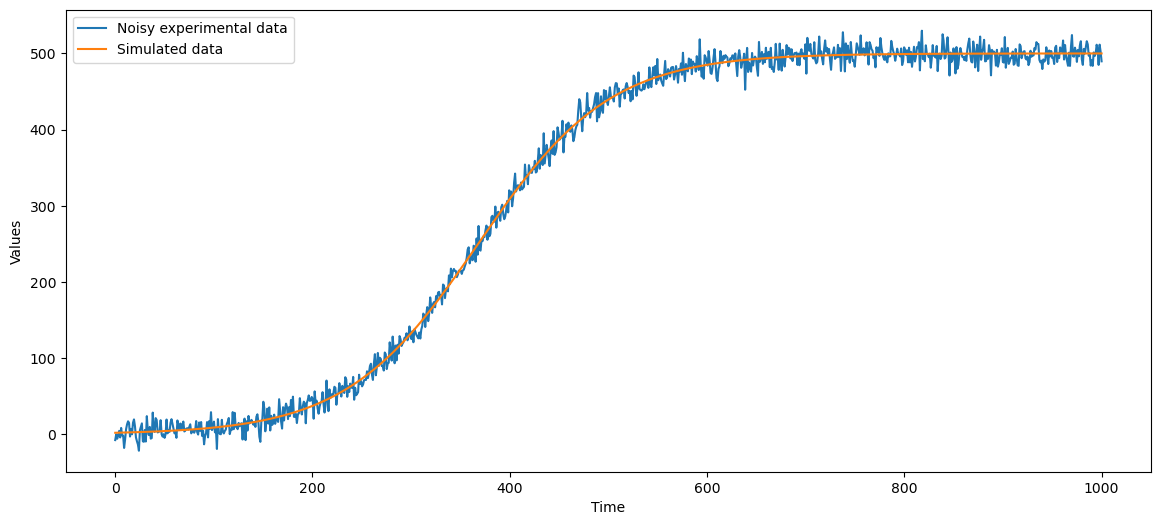

In [20]:
values2 = model.simulate(found_parameters, times)

plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy experimental data')
plt.plot(times, values2, label='Simulated data')
plt.legend()
plt.show()

Looks like a great fit!

Because it's still a toy problem, we can look at the parameter values as well:

In [21]:
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Found solution:          True parameters:
 1.49976195003408211e-02     1.49999999999999994e-02
 5.00033584916473444e+02     5.00000000000000000e+02


So it looks like we were close, but not _exactly_ at the right parameters.

Why didn't we find _exactly_ the right solution in the noisy case?

To investigate this, we start by looking at the error measure, evaluated at the true solution and at the obtained solution:

In [22]:
print('Error at obtained solution: ')
print(error(found_parameters))

print('Error at true solution: ')
print(error(real_parameters))

Error at obtained solution: 
108836.73282976612
Error at true solution: 
108838.70455385314


Another way to compare them is to plot the error function on a line drawn between these points:

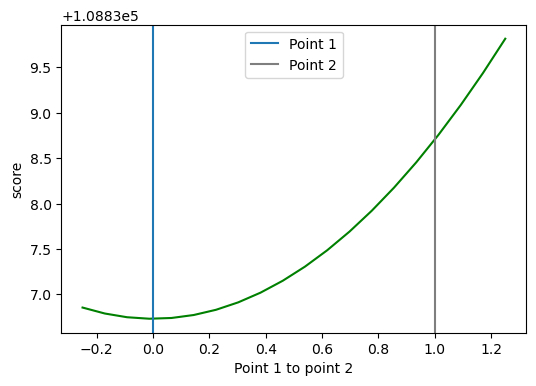

In [23]:
import pints.plot
fig, axes = pints.plot.function_between_points(error, point_1=found_parameters, point_2=real_parameters)
axes.set_ylabel('score')
plt.show()

So it looks like we found a solution that's slightly _better_ than the true solution - how can that be?

The answer comes from the noise we added to our data: it seems the optimiser is able to adjust the model parameters _so that the model reproduces some aspects of the noise signal_.

If we re-run this example (with a different random seed) we'll obtain an error of a slightly different size and direction.
In other words, we can treat our noise as a [finite sample from some distribution](https://en.wikipedia.org/wiki/Sampling_distribution) (in this case a Normal distribution), so that the parameters we infer from this noisy signal will have a slight randomness that should (on average) get worse with an increased variance (noise amplitude) but better with an increased sample size (higher sampling rate).

## Using the "controller" interface to change optimiser settings

In the examples above we ran the optimisation using [`pints.optimise`](https://pints.readthedocs.io/en/stable/optimisers/running.html#pints.optimise).
This is OK for small problems, but for many applications we prefer the extra control offered by the [`OptimisationController`](https://pints.readthedocs.io/en/stable/optimisers/running.html#pints.OptimisationController) class.

This is slightly more verbose:

In [24]:
opt = pints.OptimisationController(error, x0, boundaries=boundaries, method=pints.XNES)
found_parameters, found_value = opt.run()

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     6      4.07e+07  4.07e+07   0:00.0
1     11     4.07e+07  4.25e+07   0:00.0
2     16     4.07e+07  4.08e+07   0:00.0
3     21     4.07e+07  4.1e+07    0:00.0
20    122    3.75e+07  3.8e+07    0:00.0
40    224    2.07e+07  2.07e+07   0:00.1
60    344    1.95e+07  1.96e+07   0:00.1
80    464    1.2e+07   1.2e+07    0:00.2
100   584    113406    120835.3   0:00.2
120   704    108838.6  108846.7   0:00.2
140   824    108837.1  108837.7   0:00.3
160   944    108836.7  108836.7   0:00.3
180   1064   108836.7  108836.7   0:00.3
200   1184   108836.7  108836.7   0:00.3
220   1304   108836.7  108836.7   0:00.4
240   1424   108836.7  108836.7   0:00.4
260   1544   108836.7  108836.7   0:00.4
280   1664   108836.7  108836.7   0:00.4
300   1784   108836.7  108836.7   0:00.5
320   1904   108836.7  108836.7   0:00.5
340   2024   10

but much more flexible. For example, we can change the stopping criteria to make it halt quicker:

In [25]:
opt = pints.OptimisationController(error, x0, boundaries=boundaries, method=pints.XNES)
opt.set_max_unchanged_iterations(50)
found_parameters, found_value = opt.run()

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     6      5.09e+07  5.09e+07   0:00.0
1     8      5.09e+07  5.51e+07   0:00.0
2     12     4.84e+07  4.84e+07   0:00.0
3     18     4.14e+07  4.14e+07   0:00.0
20    101    1.45e+07  1.99e+07   0:00.0
40    218    8486980   8486980    0:00.0
60    338    322192.4  322192.4   0:00.1
80    458    108864.1  108864.1   0:00.1
100   578    108836.8  108836.8   0:00.1
120   698    108836.7  108836.7   0:00.1
140   818    108836.7  108836.7   0:00.2
160   938    108836.7  108836.7   0:00.2
180   1058   108836.7  108836.7   0:00.2
200   1178   108836.7  108836.7   0:00.2
220   1298   108836.7  108836.7   0:00.2
240   1418   108836.7  108836.7   0:00.3
260   1538   108836.7  108836.7   0:00.3
280   1658   108836.7  108836.7   0:00.3
297   1754   108836.7  108836.7   0:00.3
Halting: No significant change for 50 iterations.


The controller handles

- logging to screen or disk
- parallelisation
- stopping criteria (*although optimisers may also tell the controller to stop, for example if they can detect they are stuck)

For example, we can tweak the logging output with:

In [26]:
opt = pints.OptimisationController(error, x0, boundaries=boundaries, method=pints.XNES)
opt.set_log_interval(100, warm_up=5)
found_parameters, found_value = opt.run()

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     6      5.43e+07  5.43e+07   0:00.0
1     11     4.05e+07  4.05e+07   0:00.0
2     15     4.05e+07  4.1e+07    0:00.0
3     21     4.05e+07  4.07e+07   0:00.0
4     27     3.85e+07  3.85e+07   0:00.0
5     31     3.52e+07  3.52e+07   0:00.0
100   574    1831729   1831729    0:00.1
200   1174   108836.7  108836.7   0:00.2
300   1774   108836.7  108836.7   0:00.3
400   2374   108836.7  108836.7   0:00.4
500   2974   108836.7  108836.7   0:00.5
552   3280   108836.7  108836.7   0:00.6
Halting: No significant change for 200 iterations.


This shows the first 5 iterations (the "warm up") but then logs only every 100th iteration.

Finally, we can ask the controller for a reference to the optimiser object, and use that to configure optimiser-specific settings.
In our example, we set a property of [XNES](https://pints.readthedocs.io/en/stable/optimisers/xnes.html):

In [27]:
opt = pints.OptimisationController(error, x0, boundaries=boundaries, method=pints.XNES)
opt.optimiser().set_population_size(12)
found_parameters, found_value = opt.run()

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 12
Iter. Eval.  Best      Current   Time    
0     11      4.08e+07  4.08e+07   0:00.0
1     23      4.07e+07  4.07e+07   0:00.0
2     31      3.97e+07  3.97e+07   0:00.0
3     41      3.69e+07  3.69e+07   0:00.0
20    205     1.43e+07  1.54e+07   0:00.1
40    436     1.01e+07  1.01e+07   0:00.1
60    676     3471115   3541669    0:00.2
80    916     117864.2  117864.2   0:00.2
100   1156    108836.7  108836.9   0:00.3
120   1396    108836.7  108836.7   0:00.3
140   1636    108836.7  108836.7   0:00.4
160   1876    108836.7  108836.7   0:00.4
180   2116    108836.7  108836.7   0:00.5
200   2356    108836.7  108836.7   0:00.5
220   2596    108836.7  108836.7   0:00.6
240   2836    108836.7  108836.7   0:00.6
260   3076    108836.7  108836.7   0:00.6
280   3316    108836.7  108836.7   0:00.7
300   3556    108836.7  108836.7   0:00.7
320   3796    108836.7  108836.7   